In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

# sstの陸面をマスクする関数
def mask(x):
    m = ma.masked_where(x>9999, x)
    z = ma.masked_where(m==0, m)
    #f = ma.filled(z, np.nan) # for masking
    f = ma.filled(z, 0) # for filing with 0
    return f

# (緯度、経度、時間)の三次元情報を => (空間, 時間)の二次元行列に変換する関数
def latlon_to_X(var):
    # 三次元情報それぞれのshapeを取得
    imt, jmt, tmt = var.shape
    # 出力行列Xのshapeを決定
    X = np.zeros((imt*jmt, tmt))
    
    # 行列に変換
    cc = 0 # 行列Xの空間次元のインデックス
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                X[cc, :] = np.squeeze(var[ii, jj, :])
                cc = cc + 1
    X = np.squeeze(X[0:cc, :]) #squeezeは長さが1の軸が存在する場合に取り除くための保険
    return X

# 二次元行列を三次元に変換する関数
def X_to_latlon(X):
    #　対象とする地域の降水データグリッドサイズが20x20の行列なので、手動でimt,jmtを設定
    imt, jmt = 20, 20
    
    SVDs = np.zeros((imt, jmt))
    
    # 行列を三次元情報に復元
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            SVDs[ii, jj] = X[cc]
            cc += 1
    
    return SVDs

def PQ_to_latlon(P, var):
    # 行列のサイズを得る
    smt, mmt = P.shape
    imt, jmt, kmt = var.shape
    
    # 出力するデータ行列を初期化しておく(この時、最大サイズ(すべて海)を仮定)
    SVDs = np.zeros((imt, jmt, mmt))
    
    # lat-lon行列の作成
    cc = 0 # 何番目のNaNでなはない格子なのかを数えるカウンター
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                SVDs[ii, jj, :] = P[cc, :]
                cc = cc + 1
            else:
                SVDs[ii, jj, :] = np.nan
    return SVDs

# sstを可視化するための関数
def show_sst(image, img_extent, vmin=-1.5, vmax=1.5):
    projection = ccrs.PlateCarree(central_longitude=180)
    cm = plt.get_cmap('seismic')

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                     norm=Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='horizontal')
    plt.show()

# prcpを可視化するための関数
def show_prcp(image, vmin=-1.5, vmax=1.5):
    projection =ccrs.PlateCarree(central_longitude=180)
    cm = plt.get_cmap('seismic')
    img_extent = (-90, -70, 5, 25) # location=(N5-25, #90-110)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                     norm=Normalize(vmin=vmin, vmax=vmax)) # vminとvmaxは結果を見て見やすいように調整
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='vertical')
    plt.show()

# モデル番号1, 年1851の海面温度とタイ上空降水図示

(42, 165, 24, 72) (42, 165, 20, 20)


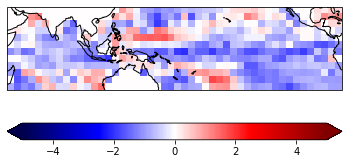

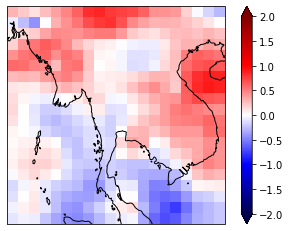

In [2]:
# データ保存場所のパスを記述
workdir = '/docker/mnt/d/research/D2/cnn3'
sst_path = workdir + '/predictors/predictors_coarse_std_Apr_o.npy'
prcp_path = workdir + '/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy'

# sstとprcpのshapeを確認
# sstは5x5°解像度を使用
sst = np.squeeze(np.load(sst_path)) # [モデルの種類42, 年(1851-2014)165, 緯度(S60-N60)24, 経度(E0-360)72]
# prcpは1x1°の解像度を使用
prcp = np.load(prcp_path) # [モデルの種類42, 年(1851-2014)165, 緯度(N10-20)20, 経度(E95-110)20]
print(sst.shape, prcp.shape)

#SSTの中央太平洋とインド洋を抜き出して可視化: E45-W75, S30-N30
model_index = 0
year_index = 0
img_extent = (-135, 105, -30, 30)
sst_m0_y0 = sst[model_index, year_index, :, :]
prcp_masked = mask(sst_m0_y0)
ocean = prcp_masked[6:18, 9:57]
show_sst(ocean, img_extent, vmin=-5, vmax=5)

#PRCPについても可視化: N10-20, E95-110
prcp_m0_y0 = prcp[0, 0, :, :]
show_prcp(prcp_m0_y0, vmin=-2, vmax=2)

# 内挿実験

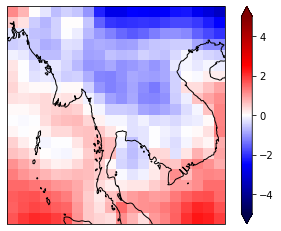

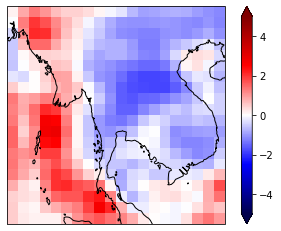

In [4]:
# 今回はモデル番号1(BCC-CSM2-MR)の1984-2014年のデータをもとに特異値行列を計算
train_int = 0 # 用いるモデルの番号始まり
train_fin = 40 # 用いるモデルの番号終わり
training_period = -165 # 用いる年の範囲
mode_int, mode_fin = 0, 30 # いくつのモードを予測に用いるか(最大400)
validation_model_index = 1 # 用いるモデルの番号
validation_year_index = -1 # 用いる年(2014年)

# sstとprcp行列を作成
umi = sst[train_int:train_fin, training_period:, 6:18, 9:57] # 太平洋とインド洋の部分を切り出し
umi = umi.transpose(2,3,0,1) # reshapeするときように転置 
umi = umi.reshape(12, 48, 40*165) # 時間次元の位置を一番後ろに移動
umi = mask(umi) # 陸域をマスク
X = latlon_to_X(umi) # SSTの行列を作成

ame = prcp[train_int:train_fin, training_period:, :, :]# 降水のデータを切り出し
ame = ame.transpose(2,3,0,1) # 時間次元の位置を一番後ろに移動
ame = ame.reshape(20, 20, (train_fin-train_int)*abs(training_period)) # 時間次元の位置を一番後ろに移動
Y = latlon_to_X(ame) # PRCPの行列を作成

# 共分散行列を作成
N = X.shape[1] # 時間方向のshape(30年)
C_XY = X@Y.T/N 

# 特異値分解で左右特異行列P, Qを取得
P, S, QT = np.linalg.svd(C_XY, full_matrices=False)
# 右特異行列を転置
Q = QT.T

tmp = sst[validation_model_index, :, 6:18, 9:57] # インド洋と太平洋を切り抜き
tmp = tmp.transpose(1,2,0) # 時間次元の位置を一番後ろに移動
tmp = mask(tmp) # 陸域をマスク
X_val = latlon_to_X(tmp) # sstの行列を作成

# 時間展開係数 Aを計算
sst_input = X_val[:, validation_year_index] # 2014年のsstをインプットとして用意
A = P.T@sst_input # 時間発展係数　=　左特異行列　＊　SST行列
# Aは意味合い的には特異値ベクトルへの射影であり(P_star)に等しい

# PRCP行列を緯度経度座標に復元
grids = 20*20 # 雨データのグリッド数(緯度グリッド20 * 経度グリッド20)
prcp_output = np.zeros(grids)
# モード毎にprcpを計算して足し合わせる
for i in range(mode_int, mode_fin):
    mode_i = Q.T[i]*A[i] # PRCPのi番目のモード = 右特異行列 * 時間発展係数B(Bが未知なのでAで代用)
    prcp_output += mode_i # 各モードを足し合わせる
    
# 可視化
# 特異値解析で得られた降水量分布
prcp_latlon = X_to_latlon(prcp_output)
latlon_norm = (prcp_latlon-np.mean(prcp_latlon))/np.std(prcp_latlon)
show_prcp(latlon_norm, vmin=-5, vmax=5)

# 元データから得られた降水量
prcp_label = prcp[validation_model_index, validation_year_index, :, :]
label_norm = (prcp_label-np.mean(prcp_label))/np.std(prcp_label)
show_prcp(label_norm, vmin=-5, vmax=5)

# モード1の特異ベクトルを海面水温と降水で図示

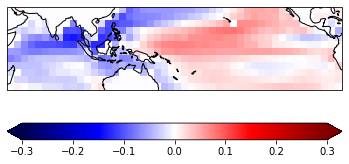

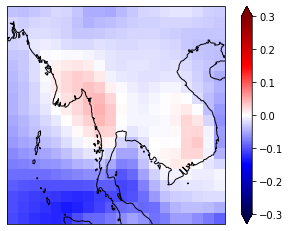

In [5]:
# モード毎の左右特異ベクトルの描写
mode_index = 1

# SSTの左特異ベクトルを描写
sst_SVDs = PQ_to_latlon(P, umi)
svd1_sst_map = sst_SVDs[:, :, mode_index]

img_extent = (-135, 105, -30, 30)
show_sst(svd1_sst_map, img_extent, vmin=-0.3, vmax=0.3)

prcp_SVDs = PQ_to_latlon(Q, ame)
svd1_prcp_map = prcp_SVDs[:, :, mode_index]
show_prcp(svd1_prcp_map, vmin=-0.3, vmax=0.3)

# 外装実験

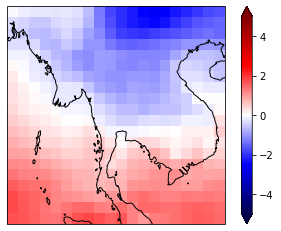

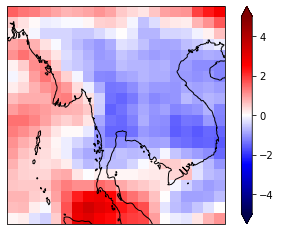

In [6]:
# 外装実験
validation_model_index = 41 # 外装に用いるモデルの番号
validation_year_index = -5 # 外装に用いる予測年
mode_int, mode_fin = 0, 5 # いくつのモードを予測に用いるか(最大400)

# 予測
tmp = sst[validation_model_index, :, 6:18, 9:57] # indian ocean and pacific ocean
tmp = tmp.transpose(1,2,0) # transpose time at last position
tmp = mask(tmp) # mask land area in sst data
X_val = latlon_to_X(tmp) # convert data (points, time)

# calculate time expansion coefficient A
sst_val = X_val[:, validation_year_index] # year:-1=2014
A_val = P.T@sst_val

# 降水の復元
grids = 20*20
prcp_val = np.zeros(grids)
for i in range(mode_int, mode_fin):
    mode_i = Q.T[i]*A_val[i]
    prcp_val += mode_i
    
# 可視化
# 特異値解析で得られた降水量分布
prcp_val_lonlat = X_to_latlon(prcp_val)
val_latlon_norm = (prcp_val_lonlat-np.mean(prcp_val_lonlat))/np.std(prcp_val_lonlat)
show_prcp(val_latlon_norm, vmin=-5, vmax=5)

# 元データから得られた降水量
prcp_label = prcp[validation_model_index, validation_year_index, :, :]
label_norm = (prcp_label-np.mean(prcp_label))/np.std(prcp_label)
show_prcp(label_norm, vmin=-5, vmax=5)